# This file does something

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from datetime import datetime
import torchvision
import torch
%matplotlib inline
import tkinter
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import utils
import time
import random
from torch.optim import lr_scheduler
from typing import List
import os
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from pathlib import Path
print("Torch Version: ", torch.__version__)
print("Cuda available?", torch.cuda.is_available())

Torch Version:  1.5.0
Cuda available? True


In [3]:
LABS_DIR = Path('C:/Labs/')
DATA_DIR = LABS_DIR/'DataDividedByGender'
# DATA_DIR_M = LABS_DIR/'DataDomains'/'Male'
# DATA_DIR_F = LABS_DIR/'DataDomains'/'Female'
# DATA_DIR_U = LABS_DIR/'DataDomains'/'Undecided'

In [4]:
# Data augmentation and normalization for training
# for validatin we use normalization and resize (for train we also change the angle and size of the images)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
#        transforms.RandomResizedCrop(224, scale=(0.96, 1.04), ratio=(0.92, 1.08)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Data Loader

In [5]:
BATCH_SIZE = 32
SAMPLE_SIZE = None 


''' The function takes the data loader and a parameter  '''
def create_train_val_slice(image_datasets,sample_size=None,val_same_as_train=False):
    img_dataset = image_datasets # reminder - this is a *generator* of the dataset
    
    # clone the image_datasets_reduced[train] generator for the val
    if val_same_as_train:
        img_dataset['val'] = list(img_dataset['train'])
        
    dataset_sizes = {x: len(img_dataset[x]) for x in ['train', 'val']}

    if sample_size: # return the whole data set
        sample_n = {x: random.sample(list(range(dataset_sizes[x])), sample_size) for x in ['train', 'val']}
        img_dataset = {x: torch.utils.data.Subset(img_dataset[x], sample_n[x]) for x in ['train', 'val']}
        dataset_sizes = {x: len(img_dataset[x]) for x in ['train', 'val']}
       
    dataloaders = {x: torch.utils.data.DataLoader(img_dataset[x], batch_size=BATCH_SIZE,
                                                      shuffle=True, num_workers=0) for x in ['train', 'val']}
    
    return dataloaders, dataset_sizes


# ''' The function takes the data loader and a parameter  '''
# def create_train_val_slice(image_datasets,sample_size=None,val_same_as_train=False):
#     dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
        
#     if not sample_size: # return the whole data set
#         dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
#                                                       shuffle=True, num_workers=0)
#                       for x in ['train', 'val']}
#         return dataloaders, dataset_sizes
    
#     sample_n = {x: random.sample(list(range(dataset_sizes[x])), sample_size)
#                 for x in ['train', 'val']}

#     image_datasets_reduced = {x: torch.utils.data.Subset(image_datasets[x], sample_n[x])
#                               for x in ['train', 'val']}
    
#     #clone the image_datasets_reduced[train] generator for the val
#     if val_same_as_train:
#         image_datasets_reduced['val'] = list(image_datasets_reduced['train'])
# #         image_datasets_reduced['train'] = image_datasets_reduced['val']
        
#     dataset_sizes = {x: len(image_datasets_reduced[x]) for x in ['train', 'val']}

#     dataloaders_reduced = {x: torch.utils.data.DataLoader(image_datasets_reduced[x], batch_size=BATCH_SIZE,
#                                                   shuffle=True, num_workers=1) for x in ['train', 'val']}
#     return dataloaders_reduced, dataset_sizes


image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

class_names = image_datasets['train'].classes

my_data, dataset_sizes =  create_train_val_slice(image_datasets,sample_size=SAMPLE_SIZE,val_same_as_train=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Classes: ", class_names) 
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

Classes:  ['Female', 'Male']
Train image size: 5773
Validation image size: 1449


In [6]:
def get_model():
    model_conv = torchvision.models.resnet18(pretrained=True)
    #model_conv = torchvision.models.resnet50(pretrained=True)
    #model_conv = torchvision.models.resnet101(pretrained=True)

    num_ftrs = model_conv.fc.in_features #probably the feature exctractor
    model_conv.fc = nn.Linear(num_ftrs, 1)
#     model_conv.fc = nn.Sequential(
#         nn.Linear(num_ftrs, 1),
#         nn.Sigmoid(),
#     )
    
    
    #utils.freeze_layers_grad(model_conv)
    
    model_conv = model_conv.to(device)
    return model_conv

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated  

# Show sample of the data for review

classes=tensor([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 1])


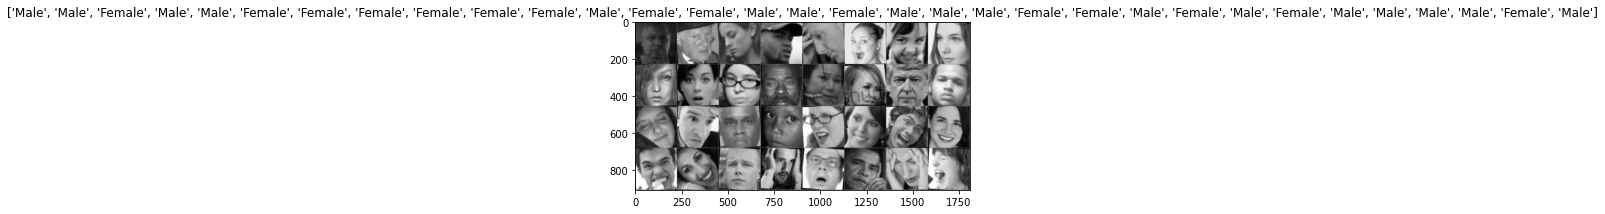

classes=tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1])


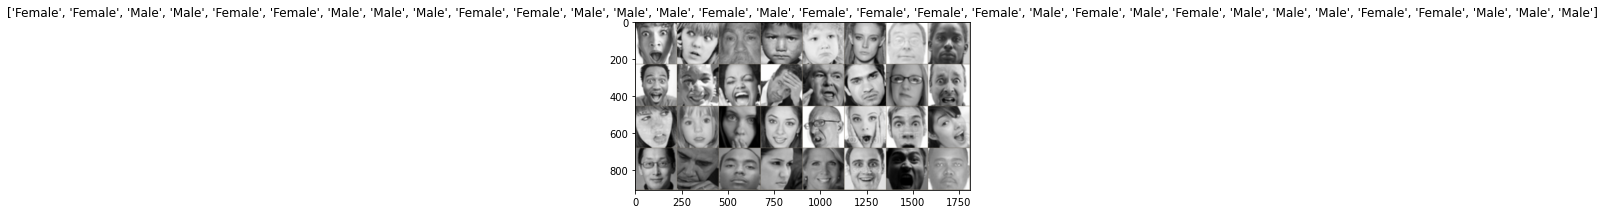

In [8]:
# # Get a batch of training data
inputs, classes = next(iter(my_data['train']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])


# # Get a batch of validation data
inputs, classes = next(iter(my_data['val']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])

In [9]:
def tensors_to_dataframe(tensors:List):
    # Each element in list is a triplet: tensor,column_name,tensor_type
    list_of_series_from_tensors = []
    for tensor,column_name,tensor_type in tensors:
        series = pd.Series(tensor.detach().cpu().numpy(),name=column_name).astype(tensor_type)
        list_of_series_from_tensors.append(series)
    full_df = pd.concat(list_of_series_from_tensors,axis=1)
    return full_df

def convert_target_and_prediction_to_list_of_values_dict(df,output_column_name):
    compared_results_columns = ['Label','Prediction']
#     print("df=")
#     print(df)
#     print(df[compared_results_columns])
    compared_results_values = df[compared_results_columns].drop_duplicates(keep='first')
#     print("compared_results_values=",compared_results_values)
    grouped = df.groupby(compared_results_columns)
    values_by_index_as_list = grouped.agg({output_column_name:lambda x:list(x)})
#     print("values_by_index_as_list=",values_by_index_as_list)
    results_index = values_by_index_as_list.index.values
#     print("results_index=",results_index)
    new_results_index = [f'{compared_results_columns[0]}:{t},{compared_results_columns[1]}:{p}' for t,p in results_index]
#     print("new_results_index=",new_results_index)
    values_by_index_as_list.index = new_results_index
    return values_by_index_as_list[output_column_name].to_dict()
   
def update_sigmoid_value_dct(current,update):
    for update_key, update_list in update.items():
        current[update_key] =  current.get(update_key,[]) + update_list
    return current


def display_histogram_for_options(epoch,values_dct):
    fig, axs = plt.subplots(1,4,figsize=(20,5),sharex=True, sharey=True)
    fig.suptitle(f'Epoch: {epoch}')
    for i,key in enumerate(sorted(values_dct.keys())):
        no_bins = 20    
        axs[i].hist(values_dct[key],np.arange(0,1,1/no_bins),label=key, histtype='bar')
        axs[i].text(x=0.5, y=0.9, s=key + '\n' + str(len(values_dct[key])),
                    fontsize=18, horizontalalignment='center', verticalalignment='center',
                    transform=axs[i].transAxes)
    plt.show()


In [10]:
THRESHOLD = 0.5

def train_model(data, model, criterion, optimizer, scheduler, num_epochs=2, writer=None):
    since = time.time()

    train_accuracy_history = []
    train_loss_history = []

    test_accuracy_history = []
    test_loss_history = []

    sigmoid_values_by_result_per_epoch = []

    print("Starting epochs")
    for epoch in range(1,num_epochs+1):
        print()
        print(f'Epoch: {epoch} of {num_epochs}')
        model.train()  # Set model to training mode
        running_test_loss = 0.0
        running_corrects = 0.0 
        
        sigmoid_values_by_result_dct = {}
        
        for i, (inputs, labels) in enumerate(data['train']):
            # data['train'] contains (input,labels) for every batch (so i=[1...NUM OF BATCHES]
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs).squeeze()
                #_, preds = torch.max(outputs, 1)
#                 preds = torch.round(outputs)
                sigmoid_outputs = torch.sigmoid(outputs)
                preds = (sigmoid_outputs > THRESHOLD).double()
                loss = criterion(outputs, labels.float())

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()
                
                sample_results = tensors_to_dataframe([
                    [labels,'Label','int'],[outputs,'Output','float'],
                    [sigmoid_outputs,'Sigmoid','float'],[preds,'Prediction','int']])
                values_by_index_as_lists_dct = convert_target_and_prediction_to_list_of_values_dict(sample_results,'Sigmoid')
                sigmoid_values_by_result_dct = update_sigmoid_value_dct(sigmoid_values_by_result_dct,values_by_index_as_lists_dct)

                
                if (i % 200) == 0:  # Only sample one of 100 batches
                    pass
#                     print(f'Epoch #{epoch} , Batch #{i}, sigmoid results:')
#                     display(sample_results)
                    #display(sigmoid_values_by_result_dct)

#                 print("Train- Outputs:    ",outputs.tolist())
#                 print("Train- Predictions:",preds.int().tolist())
#                 print("Train- Labels:     ",labels.data.tolist())
#                 print("Train- Loss:     ",loss)
        
            batch_loss = loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            if writer is not None: # save train loss for each batch
                x_axis = 1000*(epoch + i/(dataset_sizes['train']//BATCH_SIZE))
                writer.add_scalar('batch loss',batch_loss/BATCH_SIZE,x_axis)

        if scheduler is not None:
            scheduler.step() #scheduler step is performed per-epoch in the training phase

        train_acc = running_corrects /dataset_sizes['train']
        if writer is not None: # save epoch accuracy
            x_axis = epoch 
            writer.add_scalar('accuracy-train',
                train_acc,
                x_axis)        
        
        epoch_loss, epoch_acc = eval_model(criterion, data, model, optimizer)
        display_histogram_for_options(epoch,sigmoid_values_by_result_dct)
        
        if writer is not None: # save epoch accuracy
            x_axis = epoch 
            writer.add_scalar('accuracy-val',
                epoch_acc,
                x_axis)

    # TODO check stop condition by overfit
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #return the last trained model
    return model

def eval_model(criterion, data, model, optimizer):
    model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0.0

    for i, (inputs, labels) in enumerate(data['val']):
        # data['val'] contains (input,labels) for every batch (so i=[1...NUM OF BATCHES]

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs).squeeze()
            #_, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels.float())
            preds = torch.sigmoid(outputs) > THRESHOLD

        # statistics - sum loss and accuracy on all batches
        running_loss += loss.item() * inputs.size(0) #item.loss() is the average loss of the batch
#         print("Eval - Outputs:    ",outputs.tolist())
#         print("Eval - Predictions:",preds.int().tolist())
#         print("Eval - Labels:     ",labels.data.tolist())
        running_corrects += torch.sum(preds == labels.data)
#         print("Eval - Running corrects:",running_corrects)

    epoch_loss = float(running_loss) / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']
    print(f'Test Loss: {epoch_loss:.4f} Test Acc: {epoch_acc:.4f}')
                
    return epoch_loss, epoch_acc

# Run experiment

Starting epochs

Epoch: 1 of 30
Test Loss: 0.6219 Test Acc: 0.7019


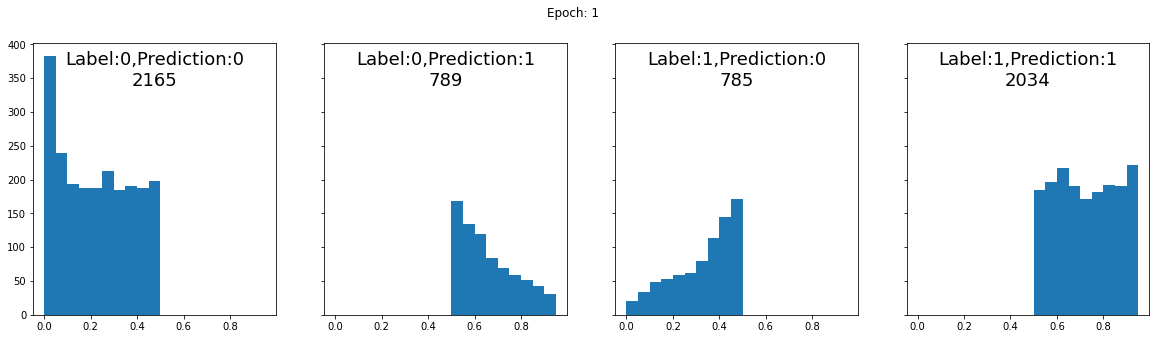


Epoch: 2 of 30
Test Loss: 1.3511 Test Acc: 0.5252


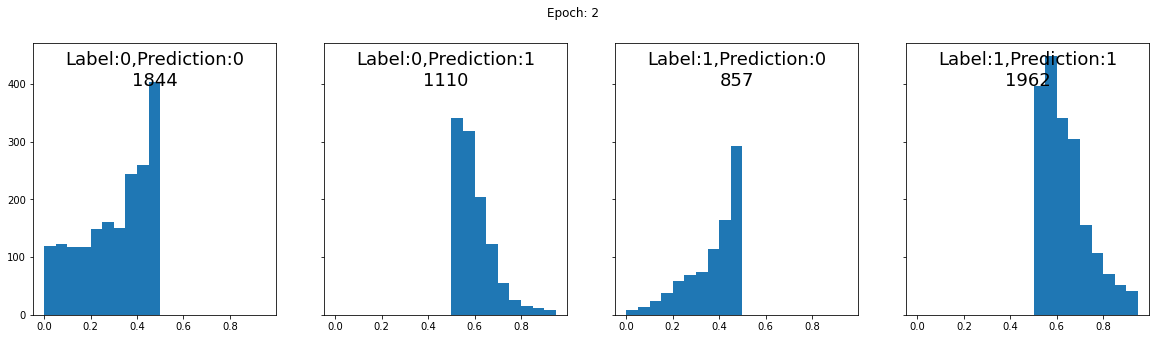


Epoch: 3 of 30
Test Loss: 1.2190 Test Acc: 0.4720


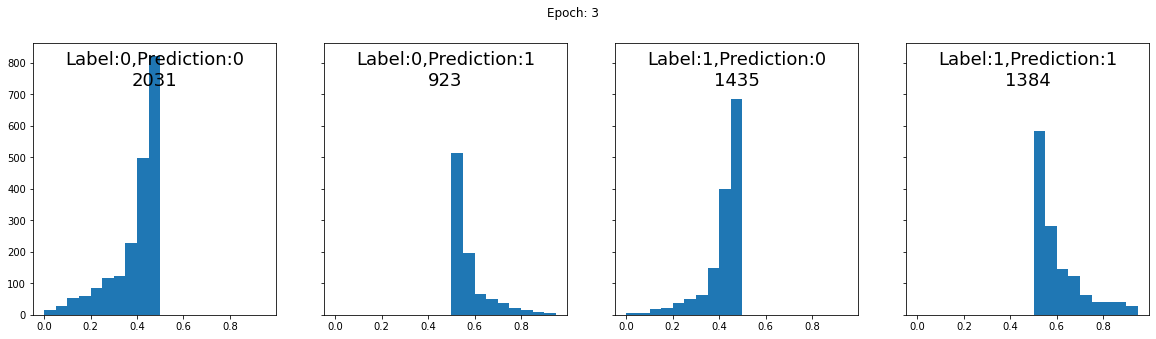


Epoch: 4 of 30
Test Loss: 0.6944 Test Acc: 0.4879


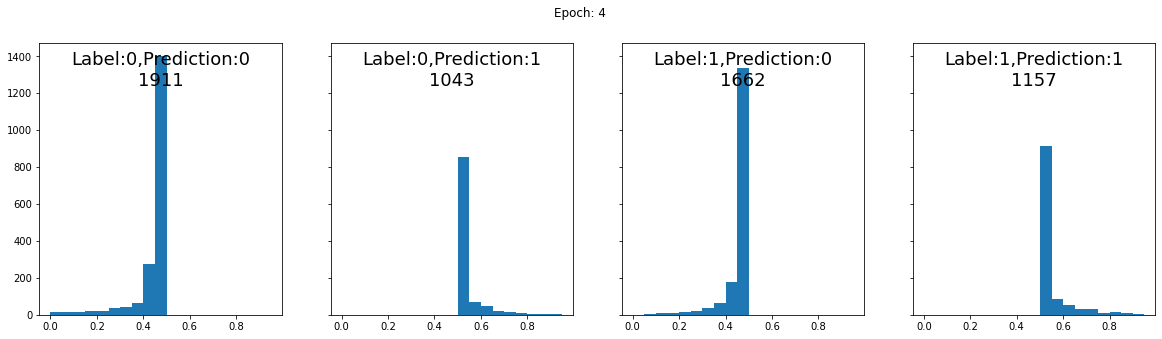


Epoch: 5 of 30
Test Loss: 0.7073 Test Acc: 0.4879


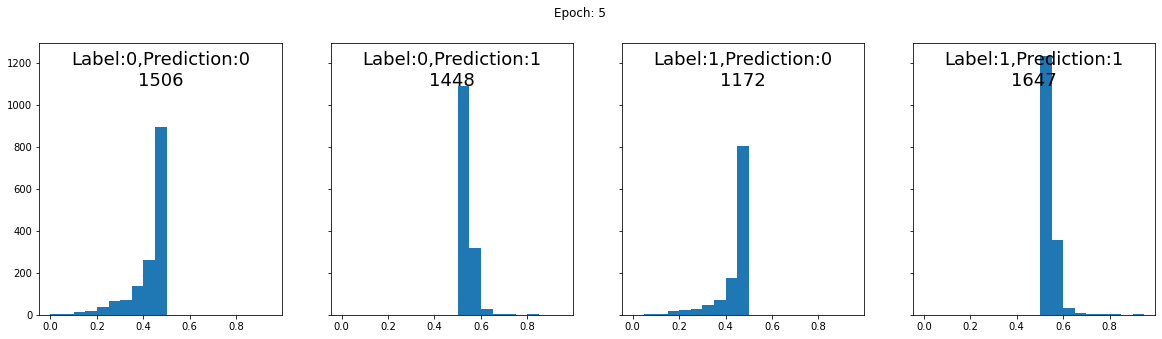


Epoch: 6 of 30
Test Loss: 0.6736 Test Acc: 0.5873


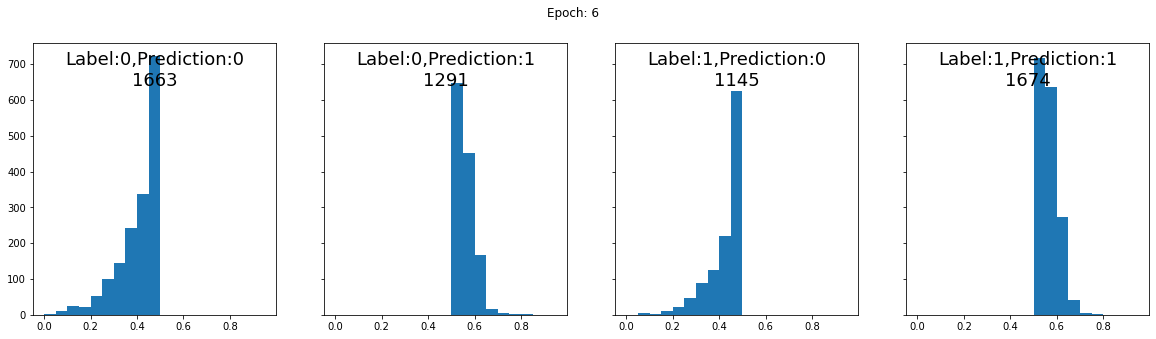


Epoch: 7 of 30
Test Loss: 0.6433 Test Acc: 0.6701


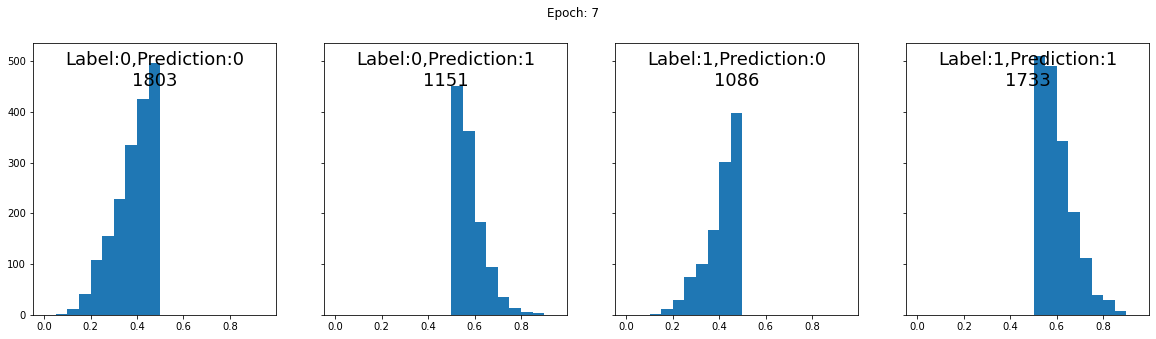


Epoch: 8 of 30
Test Loss: 0.6605 Test Acc: 0.5183


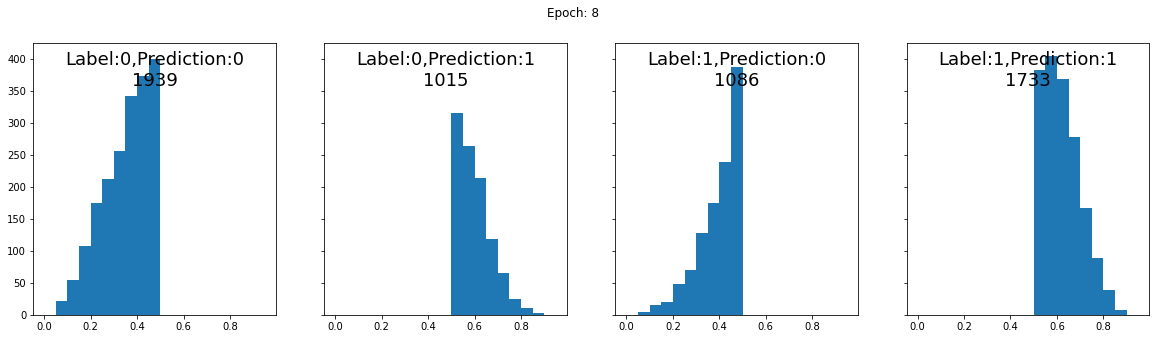


Epoch: 9 of 30
Test Loss: 0.6740 Test Acc: 0.5763


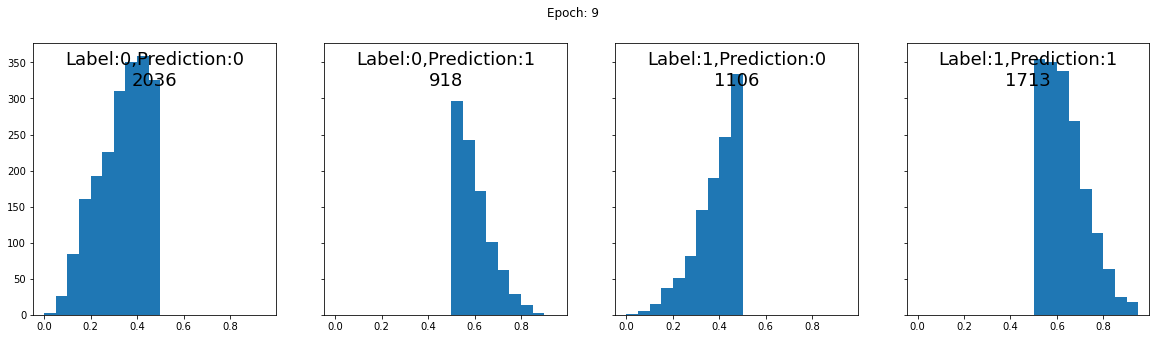


Epoch: 10 of 30
Test Loss: 0.6616 Test Acc: 0.6432


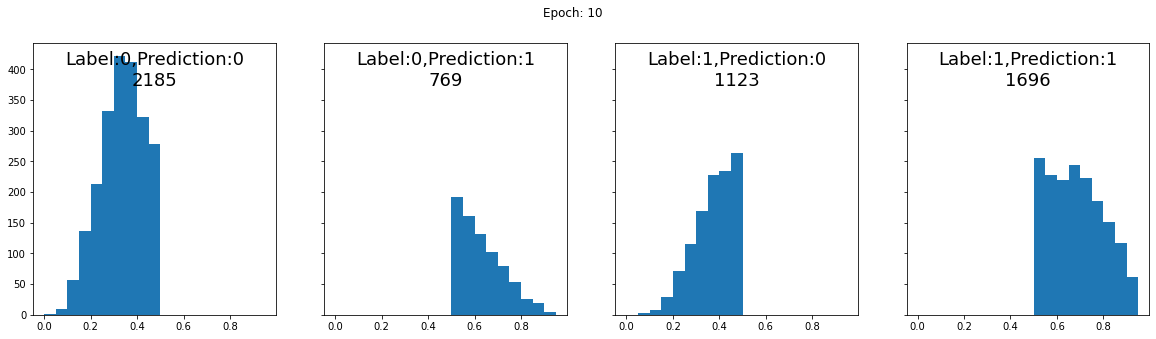


Epoch: 11 of 30
Test Loss: 0.5947 Test Acc: 0.6839


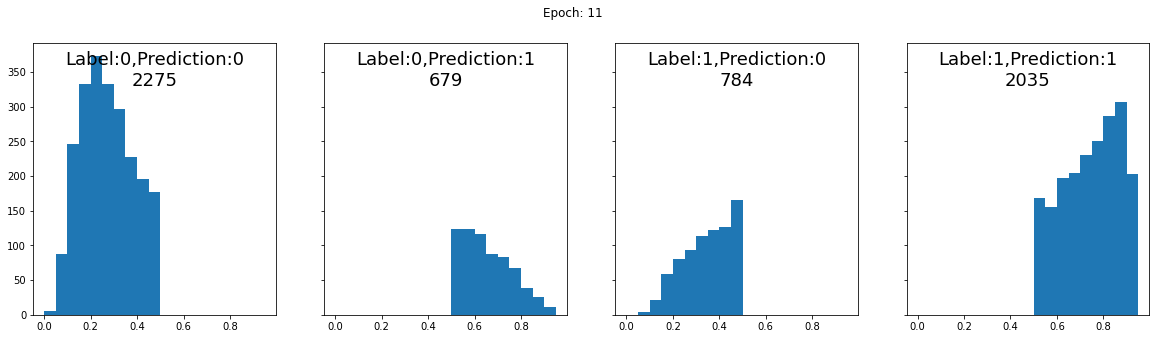


Epoch: 12 of 30
Test Loss: 0.4674 Test Acc: 0.7805


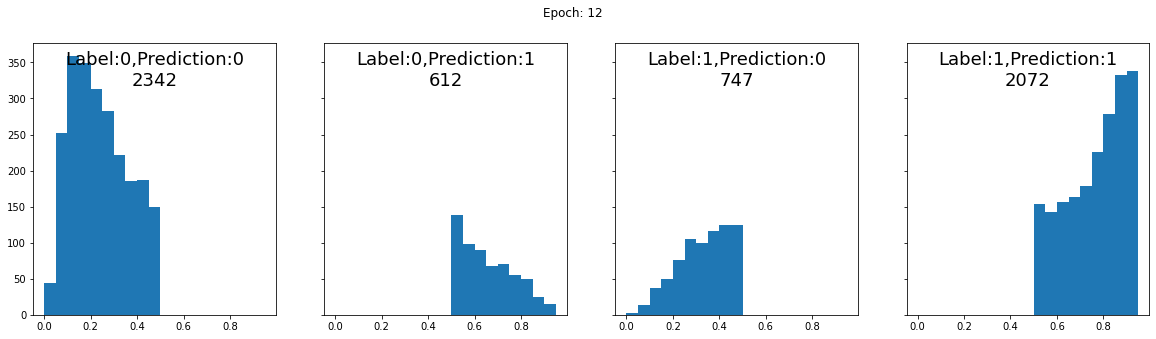


Epoch: 13 of 30
Test Loss: 0.4973 Test Acc: 0.7460


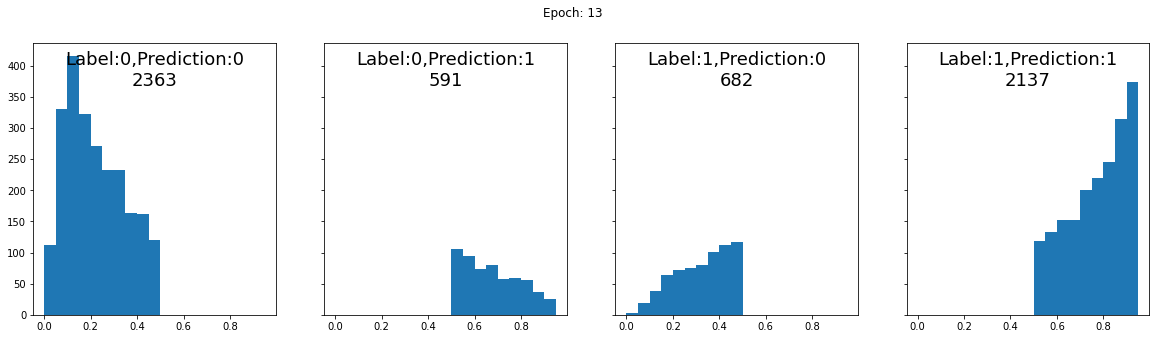


Epoch: 14 of 30
Test Loss: 0.4664 Test Acc: 0.7723


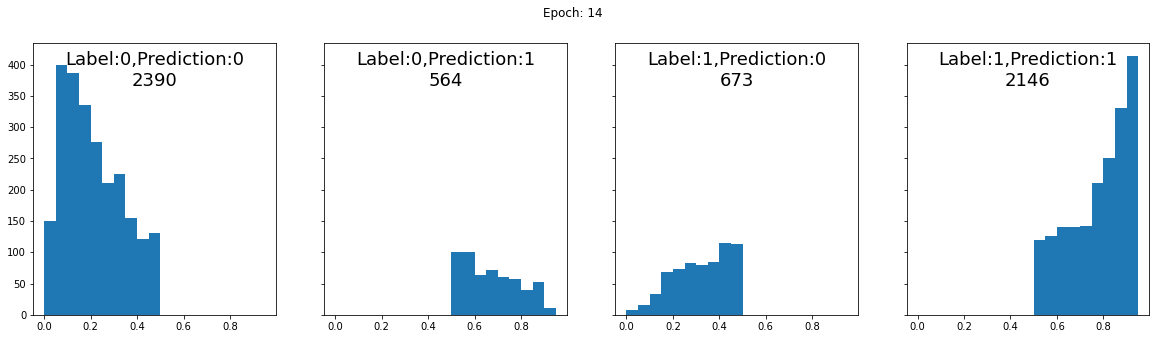


Epoch: 15 of 30
Test Loss: 0.4221 Test Acc: 0.8150


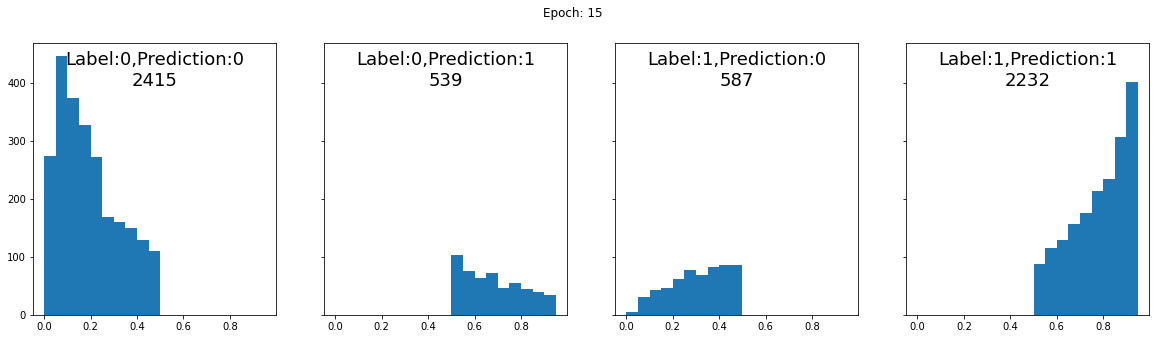


Epoch: 16 of 30
Test Loss: 0.4071 Test Acc: 0.8268


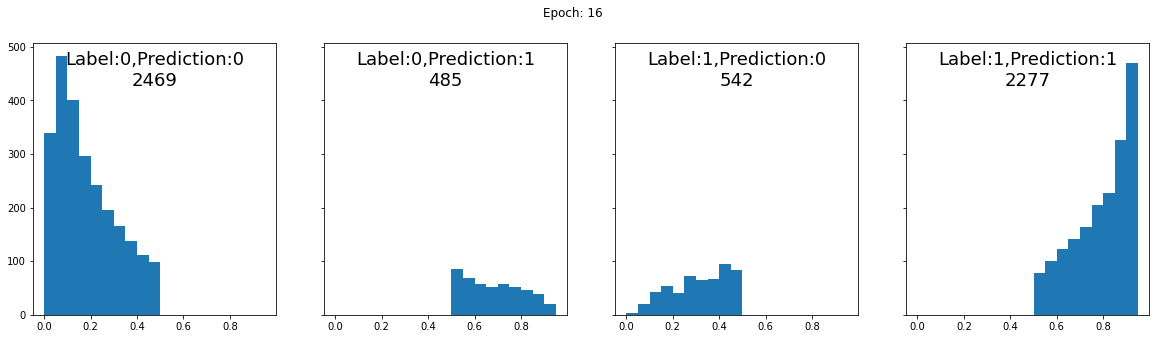


Epoch: 17 of 30
Test Loss: 0.4400 Test Acc: 0.7937


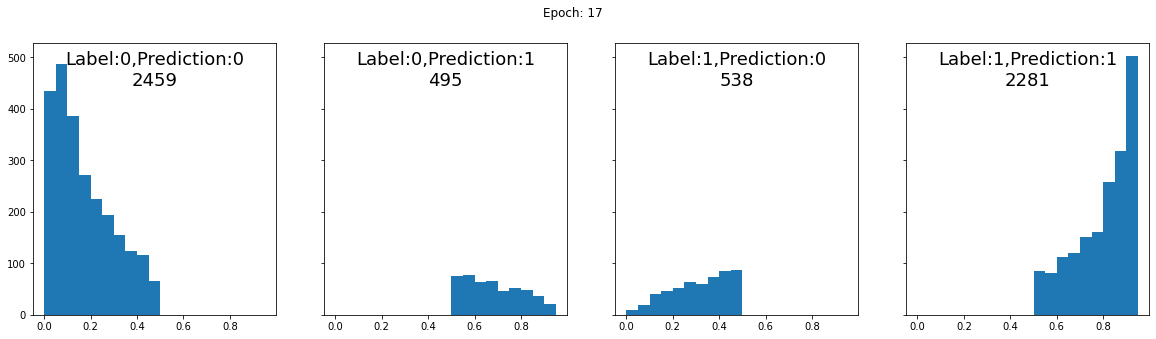


Epoch: 18 of 30
Test Loss: 0.4140 Test Acc: 0.8219


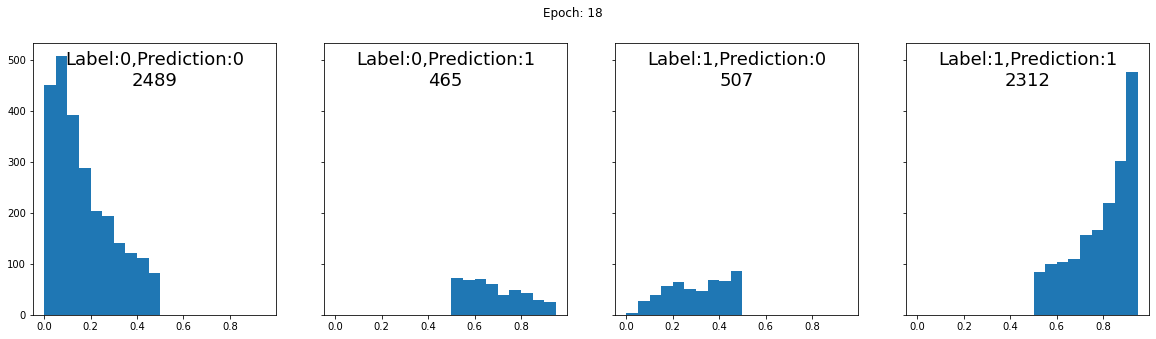


Epoch: 19 of 30
Test Loss: 0.3933 Test Acc: 0.8233


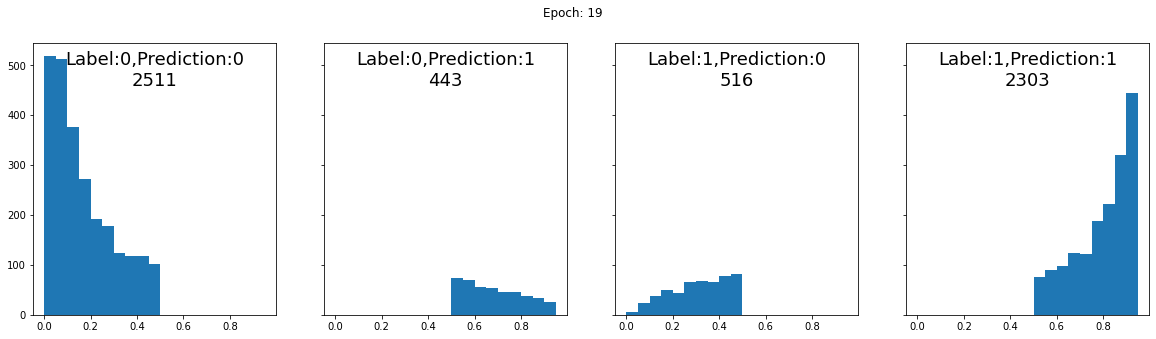


Epoch: 20 of 30
Test Loss: 0.3883 Test Acc: 0.8233


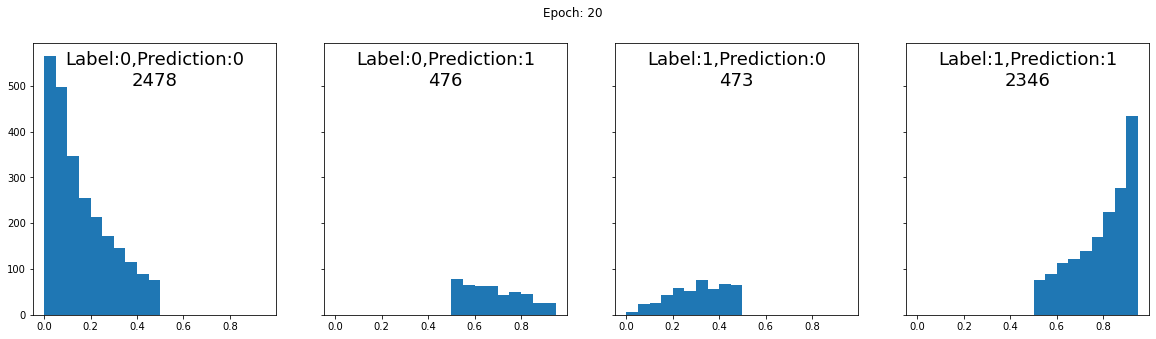


Epoch: 21 of 30
Test Loss: 0.3823 Test Acc: 0.8337


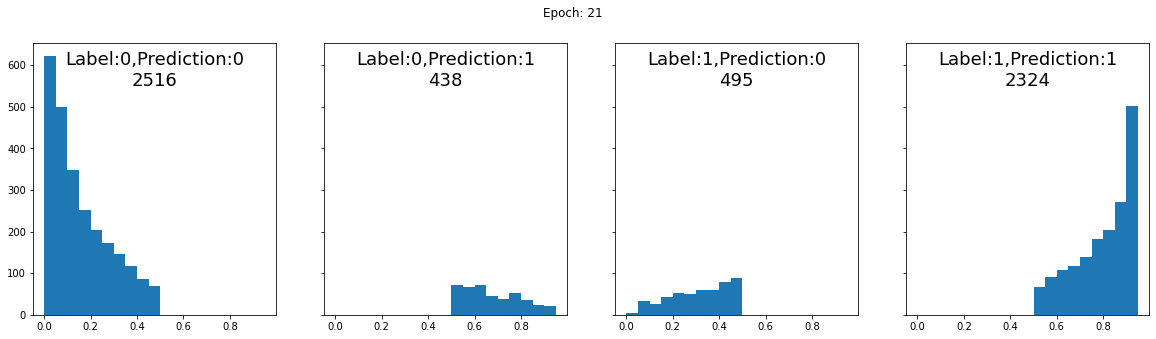


Epoch: 22 of 30
Test Loss: 0.3814 Test Acc: 0.8316


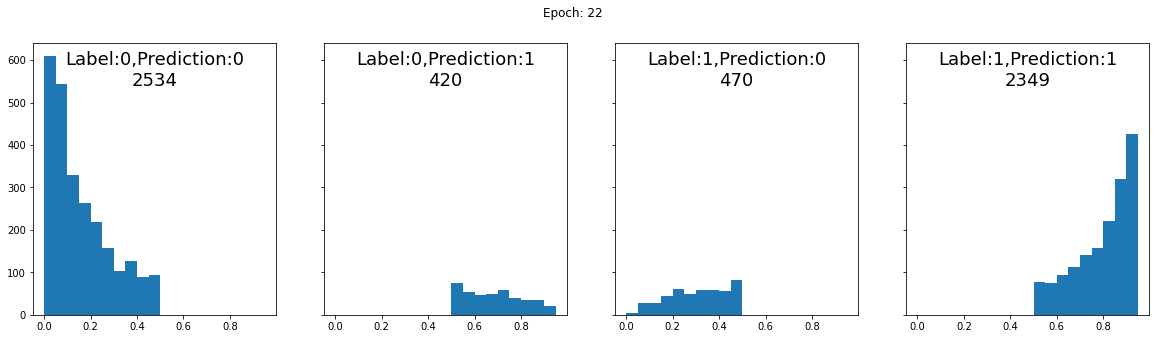


Epoch: 23 of 30
Test Loss: 0.3773 Test Acc: 0.8316


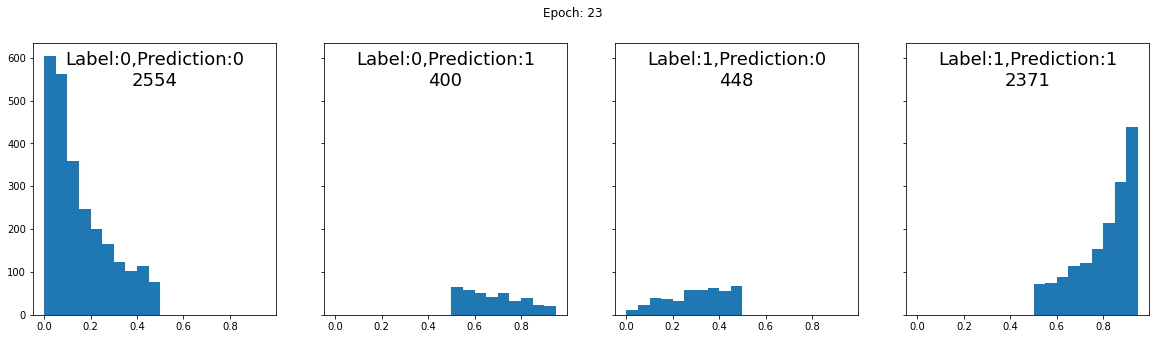


Epoch: 24 of 30
Test Loss: 0.3755 Test Acc: 0.8406


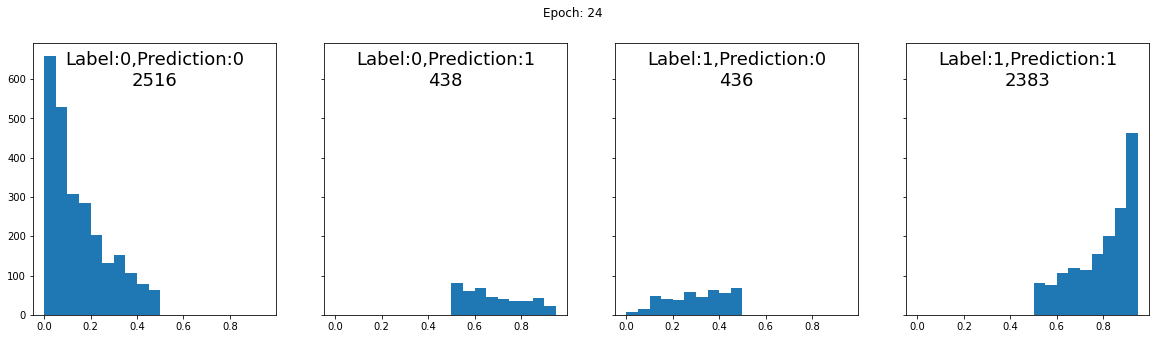


Epoch: 25 of 30
Test Loss: 0.3776 Test Acc: 0.8364


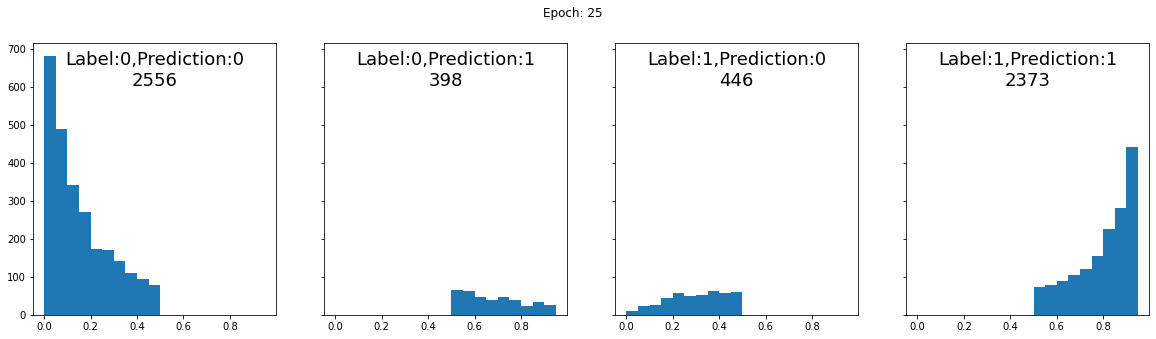


Epoch: 26 of 30
Test Loss: 0.3726 Test Acc: 0.8344


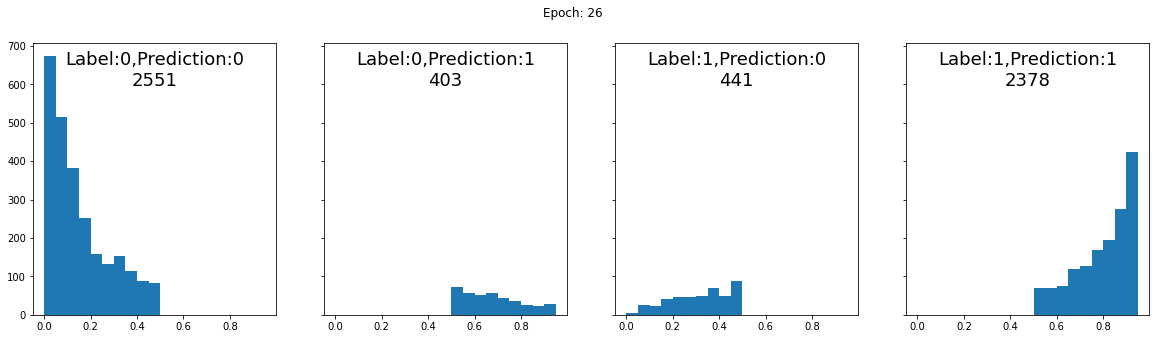


Epoch: 27 of 30
Test Loss: 0.3734 Test Acc: 0.8364


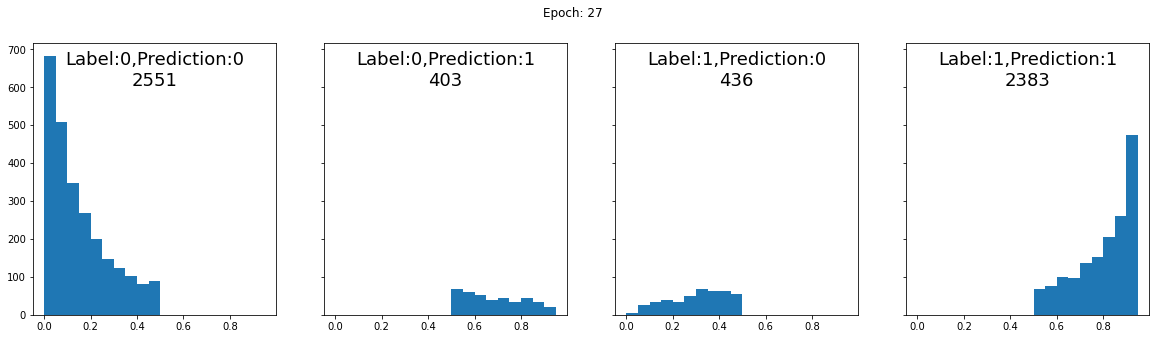


Epoch: 28 of 30
Test Loss: 0.3718 Test Acc: 0.8385


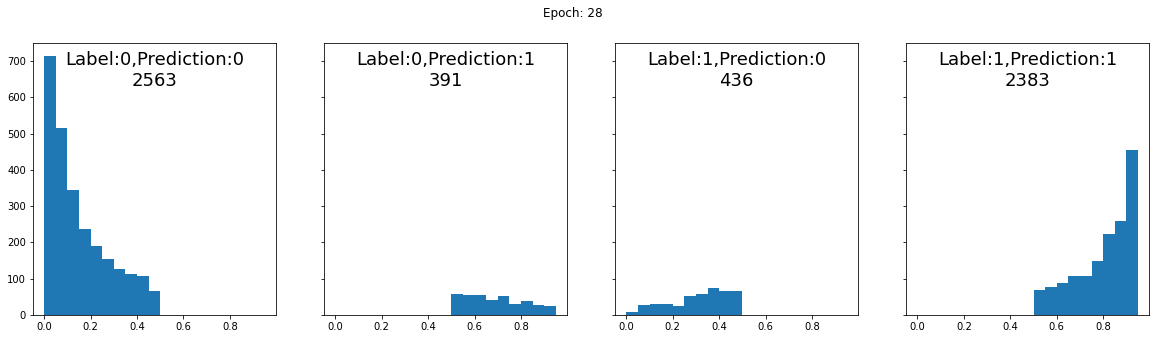


Epoch: 29 of 30
Test Loss: 0.3729 Test Acc: 0.8351


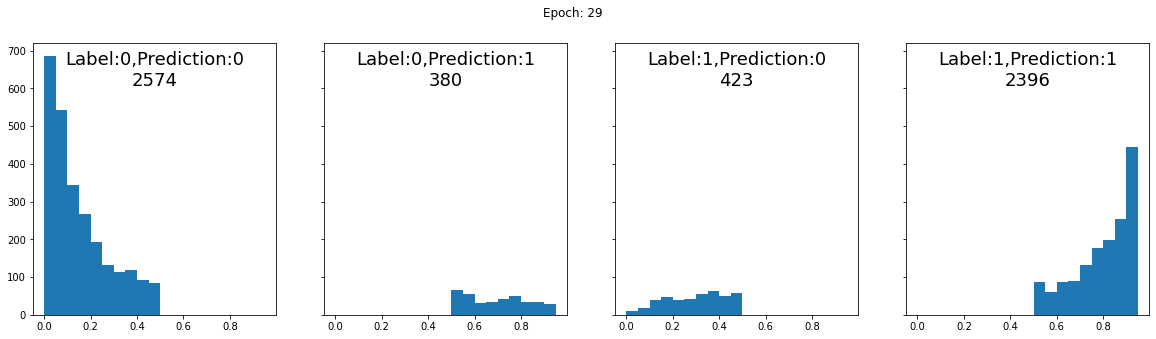


Epoch: 30 of 30
Test Loss: 0.3735 Test Acc: 0.8385


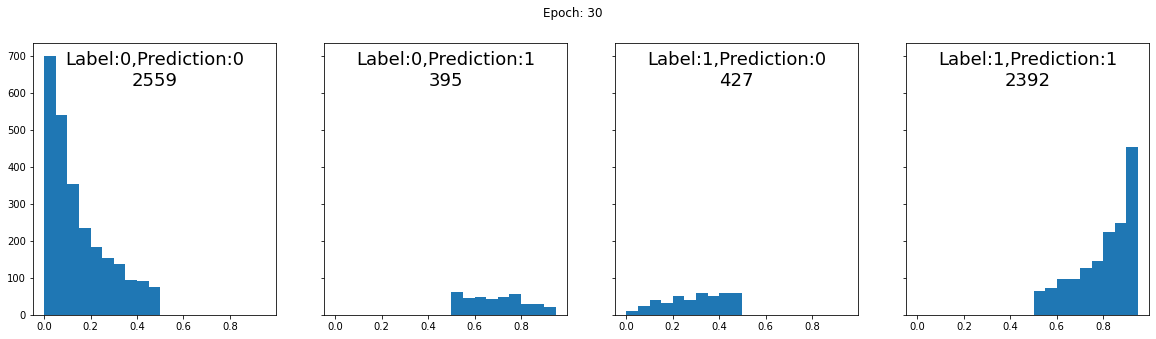

Training complete in 28m 25s


In [11]:
NUM_EPOCHS = 30

def run_experiment(data, lr_initial, gamma, step_size, weight_decay, num_of_epochs):
    """
    Gets all hyper parameters and creates the relevant optimizer and scheduler according to those params

    """
    model_net = get_model()
    #criterion = nn.CrossEntropyLoss()  # softmax+log
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_net.parameters(), lr=lr_initial, weight_decay=weight_decay)

    # decay LR by a factor of gamma every step_size epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    # check optimizer and schedular due to ADAM

    experiment_name = datetime.now().strftime("%Y%m%d-%H%M%S") + f'_lr_{lr_initial}_st_{step_size}_gma_{gamma}_wDK_{weight_decay}'
#     print("Experiment name: ", experiment_name)

    writer = SummaryWriter('runs/' + experiment_name)
    trained_model = train_model(data,
                                model_net,
                                criterion,
                                optimizer,
                                exp_lr_scheduler,
                                num_epochs=num_of_epochs,
                                writer=writer)
    return trained_model


model_conv = run_experiment(my_data, lr_initial = 0.0005,gamma = 0.3, step_size = 5, weight_decay = 0.1, num_of_epochs = 30)
                
# for lr in [0.0005, 0.0001]:
#     for scheduler_step_size in [5, 7, 9]:
#         for scheduler_gamma in [0.1, 0.3, 0.5]:
#             for weight_decay in [0.01,0.1]:
#                 model_conv = run_experiment(my_data, lr, scheduler_gamma, scheduler_step_size, weight_decay, NUM_EPOCHS)

In [12]:
# target output size of 5x7
m = nn.AdaptiveAvgPool2d((5,7))
input = torch.randn(1, 64, 8, 9)
output = m(input)
print(output.shape)
# target output size of 7x7 (square)
m = nn.AdaptiveAvgPool2d(7)
input = torch.randn(1, 64, 10, 9)
output = m(input)
# target output size of 10x7
m = nn.AdaptiveMaxPool2d((None, 7))
input = torch.randn(1, 64, 10, 9)
output = m(input)

torch.Size([1, 64, 5, 7])


In [13]:
class TrainingParams:
    def __init__(self, experiment_name, model,  lr_initial, weight_decay,step_size,gamma,num_epochs):
        self.experiment_name = experiment_name
        self.model = model
        self.label_criterion = nn.CrossEntropyLoss()  # softmax+log
        self.domain_criterion = nn.functional.binary_cross_entropy_with_logits # TODO check this loss criterion
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr_initial, weight_decay=weight_decay)
        self.scheduler= lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        self.num_epochs = num_epochs